# All calculations used were done in reference to the originial paper for Logitboost, the slides for the class, and equations shown by professor in the class: https://web.stanford.edu/~hastie/Papers/AdditiveLogisticRegression/alr.pdf

# Names: Timothy Barao, Marlan McInnes-Taylor
# FSUIDs: tjb13b, mm05f

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy import linalg as LA


In [2]:
class LogitBoost:
    def __init__(self, xt, yt, xv, yv, k):
        self.load_data(xt, yt, xv, yv)
        
        self.N_iter = k
        
        self.M = self.x_t.shape[1]
        self.N = self.x_t.shape[0]
        self.B = np.zeros(self.M)
        
        self.losses = []
    
    
    def load_data(self, x_train_file, y_train_file, x_valid_file, y_valid_file):
        if "dexter" in x_train_file:
            self.x_t = np.loadtxt(x_train_file, delimiter=',')
            self.x_v = np.loadtxt(x_valid_file, delimiter=',')
        else:
            self.x_t = np.loadtxt(x_train_file)
            self.x_v = np.loadtxt(x_valid_file)
        
        self.y_t = np.loadtxt(y_train_file) 
        self.y_v = np.loadtxt(y_valid_file) 
        
        self.y_t = self.y_t.flatten()
        self.y_v = self.y_v.flatten()
        
        self.x_t = np.insert(self.x_t, 0, 1., axis=1)
        self.x_v = np.insert(self.x_v, 0, 1., axis=1)
        
        self.N = self.x_t.shape[0]   # Rows
        self.M = self.x_t.shape[1]   # Columns         
    
    def loss(self, H_j):
        t1 = 1 + np.exp((-2 * self.y_t - 1) *H_j)
        loss = np.sum(np.log(t1+0.01))
        return loss

    def predict(self):
        xB = np.matmul(self.x_t, self.B)
        yPred = np.sign(xB)
        trainAcc = 1- np.mean(yPred == self.y_t.flatten())
        
        xB = np.matmul(self.x_v, self.B)
        yPred = np.sign(xB)
        testAcc = 1 - np.mean(yPred == self.y_v.flatten())
        return trainAcc, testAcc
    
    def train(self):
        self.losses = np.zeros(self.N_iter)
        for i in range(self.N_iter):
            # Calculate H(x)
            H = np.matmul(self.x_t, self.B)
            
            # Calculate the p,w,z to use for 1D weak classifiers
            p = (1)/(1 + np.exp(-2*H))
            # 0.0000000001 added to avoid w becoming zero
            w = (p)*(1 - p)+0.000000001 
            z = (0.5*(self.y_t + 1) - p)/(w) 
            
            coef = np.zeros((2, self.M - 1))
            newloss = np.zeros((self.M - 1, 1))
            
            for j in range(self.M-1):
                # Get jth feature, + 1 is to avoid Bias/1's added into data in first column
                x_j = self.x_t[:,j + 1]
                
                # Weighted Least Squares
                # Algorithm broken up into 7 different terms for ease of readability
                t1 = np.sum(w)
                t2 = np.sum(w * x_j)
                t3 = np.sum(w * (x_j ** 2))
                t4 = np.sum(w * z)
                t5 = np.sum(w * x_j * z)
                t6 = np.array([t3*t4-t2*t5, t1*t5 - t2*t4])
                t7 = t1 * t3 - (t2**2)
                
                # Check if 0, to avoid divide by zero later on
                if t7 == 0:
                    B_j = np.array([t4/t1, 0])
                else:
                    B_j = ((1)/(t7)) * t6 
                
                H_j = H + 0.5*(B_j[0] + B_j[1] * x_j) + 0.0000000001
                
                # Calculate the loss for this feature
                # Store the loss inside newloss, to choose the min loss later on
                newloss[j] = self.loss(H_j)
                
                # Update coef for updating the B matrix
                coef[:, j] = B_j
           
            # Choose the iteration/regression on the feature that had the min loss
            j_hat = np.argmin(newloss)
            
            # Update B matrix
            self.B[0] = self.B[0] +  0.5 * coef[0, j_hat]  
            self.B[j_hat + 1] = self.B[j_hat + 1] +  0.5 * coef[1, j_hat]
            
            # Store min loss of 1D classifiers for this iteration
            self.losses[i] = newloss[j_hat]
            
            # Print out the loss for this itertation of this k value
            #print("k: ", str(self.N_iter), "  Iteration: ", str(i), "  Loss: ", self.losses[i], sep='')
        print("")
    
    def print_features(self):
        print("X_train Objs: ", self.x_t.shape[0], "X_train Feats: ", self.x_t.shape[1])
        print("Y_train Objs: ", self.y_t.shape[0])

        print("\nX_valid Objs: ", self.x_v.shape[0], "X_valid Feats: ", self.x_v.shape[1])
        print("Y_valid Objs: ", self.y_v.shape[0])

In [3]:
def plotLosses(xVals, losses):
    plt.plot(xVals[1:], losses[1:], linestyle='-', marker='o', color='g')
    plt.grid(True)
    plt.title('Training Loss vs Boosted Iterations k=500')
    plt.xlabel('Iteration Number (i)')
    plt.ylabel('Training Loss (L_i)')
    plt.show()

In [4]:
def plotErrors(K, trainErrors, testErrors):
    plt.plot(K, trainErrors, linestyle='-', marker='o', color='r', label='Train')
    plt.plot(K, testErrors, linestyle='-', marker='o', color='b', label='Test')
    plt.grid(True)
    plt.title('Misclassification Error vs Number of Boosted Iterations')
    plt.xlabel('Number of Boosted Iterations (k)')
    plt.ylabel('Misclassification Error (%)')
    plt.legend()
    plt.show()

In [5]:
def genErrorTable(K, trainErrors, testErrors):
    errorTable = pd.DataFrame({"Training Error (%)":[0, 0, 0, 0, 0], "Test Error (%)":[0, 0, 0, 0, 0]}, index=K)
    errorTable.index.name = "Iterations"
    for k, trainErr, testErr in zip(K, trainErrors, testErrors):
        errorTable.loc[k, 'Training Error (%)'] = trainErr
        errorTable.loc[k, 'Test Error (%)'] = testErr

    return errorTable

In [6]:
def runModel(K):
    trainErrors = []
    testErrors = []
    
    for k in K:
        model = LogitBoost(x_train_file, y_train_file, x_valid_file, y_valid_file, k)
        model.train()
        if k == 500:
            losses = model.losses
        trainAccuracy, testAccuracy = model.predict()
        #print(trainAccuracy, testAccuracy)
        trainErrors.append(round((trainAccuracy) * 100, 2))
        testErrors.append(round((testAccuracy) * 100, 2))
    print("Train Errors: ", trainErrors)
    print("Test Errors: ", testErrors)
    
    return losses, trainErrors, testErrors

In [7]:
K = [10, 30, 100, 300, 500]
xVals = xVals = np.arange(1, 501)

# Madelon

In [8]:
x_train_file = "../data/MADELON/madelon_train.data"
y_train_file = "../data/MADELON/madelon_train.labels"

x_valid_file = "../data/MADELON/madelon_valid.data"
y_valid_file = "../data/MADELON/madelon_valid.labels"

In [9]:
losses, trainErrors, testErrors = runModel(K)






Train Errors:  [37.7, 35.5, 31.15, 27.7, 25.8]
Test Errors:  [41.83, 43.33, 44.0, 40.67, 41.5]


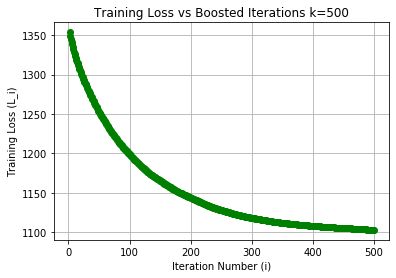

In [10]:
plotLosses(xVals, losses)

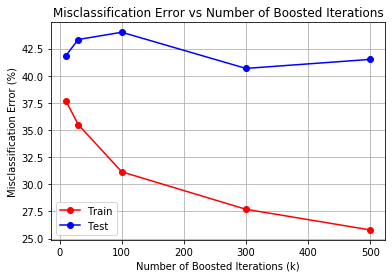

In [11]:
plotErrors(K, trainErrors, testErrors)

In [12]:
table = genErrorTable(K, trainErrors, testErrors)
table

,Training Error (%),Test Error (%)
Iterations,,
10,37.70,41.83
30,35.50,43.33
100,31.15,44.00
300,27.70,40.67
500,25.80,41.50


# Dexter

In [13]:
x_train_file = "../data/dexter/dexter_train.csv"
y_train_file = "../data/dexter/dexter_train.labels"

x_valid_file = "../data/dexter/dexter_valid.csv"
y_valid_file = "../data/dexter/dexter_valid.labels"

In [14]:
losses, trainErrors, testErrors = runModel(K)






Train Errors:  [11.0, 1.67, 0.0, 0.0, 0.0]
Test Errors:  [17.67, 13.33, 8.33, 8.67, 9.67]


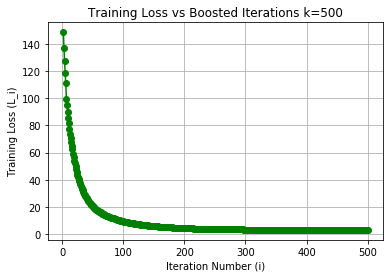

In [15]:
plotLosses(xVals, losses)

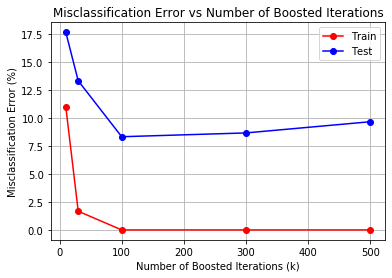

In [16]:
plotErrors(K, trainErrors, testErrors)

In [17]:
table = genErrorTable(K, trainErrors, testErrors)
table

,Training Error (%),Test Error (%)
Iterations,,
10,11.00,17.67
30,1.67,13.33
100,0.00,8.33
300,0.00,8.67
500,0.00,9.67


# Gisette

In [18]:
x_train_file = "../data/Gisette/gisette_train.data"
y_train_file = "../data/Gisette/gisette_train.labels"

x_valid_file = "../data/Gisette/gisette_valid.data"
y_valid_file = "../data/Gisette/gisette_valid.labels"


In [19]:
losses, trainErrors, testErrors = runModel(K)






Train Errors:  [7.57, 4.08, 1.37, 0.1, 0.0]
Test Errors:  [7.3, 4.4, 2.9, 2.5, 2.0]


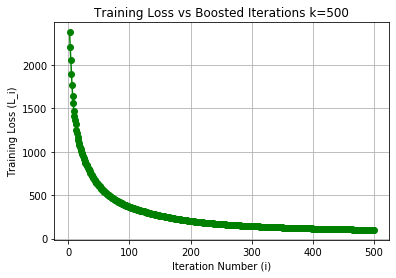

In [20]:
plotLosses(xVals, losses)

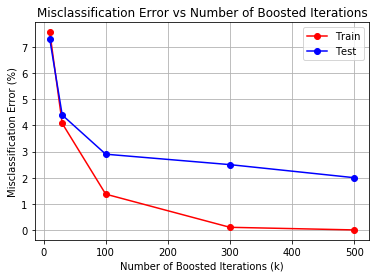

In [21]:
plotErrors(K, trainErrors, testErrors)

In [22]:
table = genErrorTable(K, trainErrors, testErrors)
table

,Training Error (%),Test Error (%)
Iterations,,
10,7.57,7.3
30,4.08,4.4
100,1.37,2.9
300,0.10,2.5
500,0.00,2.0
